# 0 : Environment_Setup

### 0.1 : Load_packages

In [1]:
# !pip install urllib2 --user
# !pip install IMDbPY BeautifulSoup4  --user
# !pip install snowflake-connector-python

In [2]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

from scipy.spatial.distance import squareform
#from scipy.cluster.hierarchy import ward
from scipy.cluster.hierarchy import  linkage
from scipy.cluster.hierarchy import fcluster

In [3]:
pd.set_option('display.max_rows', 1000)

### 0.2 : Connection to Snowflake

In [4]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# 1 : Data Load

In [5]:
import itertools as it
import os
import io
import logging

import boto3
import sys

In [6]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list ={}

s3 = boto3.resource('s3')
bucket = s3.Bucket('hbo-ingest-datascience-content-dev')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [7]:
for obj in bucket.objects.filter(Prefix='content_segmentation/AOS_all_US_prod_22_10_30.csv'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[1]
    print('Reading {0} features'.format(var_name))
    df = pd.read_csv(body, na_values = [np.NaN])
    df.columns = df.columns.str.lower()

Reading AOS_all_US_prod_22_10_30 features


In [8]:
aos_master = df[(df['consolidated_id_1'].notnull()) & (df['consolidated_id_2'].notnull())].copy()

In [9]:
power_df=run_query('''
select distinct TITLE_ID, MAX(CUMULATIVE_VIEWING_SUBS) AS  ACQUIRING_POWER
from max_prod.content_analytics.new_title_release_days_on_platform a
where 1=1
and title_level = 'Series and Movies'
GROUP BY 1
''')

In [10]:
aos_master.level_1_catg_name_1.unique()

array(['series', 'movies', 'trailer', 'special'], dtype=object)

In [11]:
input_index = aos_master[aos_master['level_1_catg_name_1'].isin(['series', 'movies', 'special'])]\
            [['consolidated_id_1']].drop_duplicates().reset_index(drop = True).reset_index()

In [12]:
input_index = input_index[input_index['index']<= 1000]

In [13]:
input_index.head()

,index,consolidated_id_1
0,0,GYsYeoAxKH8LCwgEAAAOR
1,1,GXKN_xQX5csPDwwEAAABj
2,2,GXr7SEgRi2sLCAAEAAAQu
3,3,GXdbR_gOXWJuAuwEAACVH
4,4,GVU2cggagzYNJjhsJATwo


In [14]:
input_master = aos_master.copy()

In [15]:
input_master.rename({'aos':'score',},axis=1, inplace = True)

In [16]:
input_master = input_master.merge(input_index.rename(columns={'index': 'index_1'}), on = 'consolidated_id_1', how = 'inner')

In [17]:
input_master = input_master.merge(input_index.rename(columns={'index': 'index_2', 'consolidated_id_1':'consolidated_id_2'}), on = 'consolidated_id_2', how = 'inner')

In [18]:
input_master.shape

(1002001, 11)

In [19]:
input_index=input_index.rename({'consolidated_id_1':'consolidated_id',},axis=1)

In [20]:
input_index.shape

(1001, 2)

In [21]:
power_df.shape

(6978, 2)

In [22]:
# from sklearn.preprocessing import quantile_transform

# power_df['title']=power_df['INDEX'].str.lower()
# power_df['ACQUIRING_POWER_std']= quantile_transform(power_df['ACQUIRING_POWER'].values.reshape(-1, 1), n_quantiles=100, random_state=0, copy=True).ravel()
# power_df['RETENTION_POWER_std']= quantile_transform(power_df['RETENTION_POWER'].values.reshape(-1, 1), n_quantiles=100, random_state=0, copy=True).ravel()
all_index=input_index.merge(power_df.drop_duplicates(subset = ["title_id"]),left_on='consolidated_id',right_on='title_id',how='left')

# 2 : Data Processing

In [23]:
# Turn input row-based table into a pivoted, square matrix
audience_overlap = pd.pivot_table(
    input_master, 
    values='score', 
    index=['index_1'], 
    columns=['index_2'], 
    aggfunc=np.sum
)
audience_overlap = audience_overlap.reset_index()
audience_overlap = audience_overlap.set_index('index_1')

In [24]:
audience_overlap.iloc[0:3, 0:3]

index_2,0,1,2
index_1,,,
0,1.000000,0.482156,0.516615
1,0.482156,1.000000,0.745912
2,0.516615,0.745912,1.000000


In [25]:
audience_overlap=audience_overlap.fillna(0)

In [26]:
audience_overlap.shape

(1001, 1001)

In [27]:
# Calculating the distance matrix from similarity score
# i.e., higher similarity = smaller distance

distance_matrix = 1 - audience_overlap.iloc[:, :]

In [28]:
# convert the redundant n*n square matrix form into a condensed nC2 array
# distance_matrix[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
distance_matrix = squareform(distance_matrix)

In [29]:
len(distance_matrix)

500500

# 3 : Clustering

In [ ]:
# Graph based clustering => 

In [30]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

In [31]:
# Clusters have been defined by an elbow curve approach and also silhouette to confirm
z = linkage(distance_matrix, method='ward', optimal_ordering=True)

In [32]:
# number_of_clusters = 7

In [33]:
# Generating results for K number of clusters (1 - 16)
final_result = pd.DataFrame()
# for i in range (1, 17): ### Defining the number of clusters 
for i in range(7, 8): 
    number_of_clusters = i
    clusters = fcluster(z, number_of_clusters, criterion='maxclust')
    result = all_index.copy()
    result['cluster'] = clusters
    result['number_of_cluster'] = number_of_clusters
    final_result = pd.concat([final_result, result], axis = 0)

In [34]:
final_result[final_result['number_of_cluster'] == 7].cluster.unique()

array([1, 3, 6, 7, 2, 5, 4], dtype=int32)

In [36]:
imdb_title_mapping = run_query('''
            select               
                asset.viewable_id as title_id
                , imdb_title_id as imdb_id
                , min(asset_title_long) as title_name
            from max_prod.catalog.asset_dim as asset
            join enterprise_data.catalog.wm_catalog as c
                on asset.viewable_id = c.viewable_id
            where 1=1
                and asset.content_category in ('movies', 'special')
                and length(imdb_title_id) in (9,10)
            GROUP BY 1, 2
            
            union
            
            select                
                asset.series_id as title_id
                , imdb_series_id as imdb_id
                , min(SERIES_TITLE_LONG) as title_name
            from max_prod.catalog.asset_dim as asset
            join enterprise_data.catalog.wm_catalog as c
                on asset.viewable_id = c.viewable_id
            where 1=1
                and asset.content_category in ('series')
                and length(imdb_series_id) in (9,10)
            group by 1, 2
''')

In [37]:
final_result = final_result.merge(imdb_title_mapping, on=['title_id'], how='left')

In [38]:
final_result.head()

,index,consolidated_id,title_id,acquiring_power,cluster,number_of_cluster,imdb_id,title_name
0,0,GYsYeoAxKH8LCwgEAAAOR,GYsYeoAxKH8LCwgEAAAOR,17681380.0,1,1,tt11198330,House of the Dragon
1,1,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,19335854.0,1,1,tt8772296,Euphoria
2,2,GXr7SEgRi2sLCAAEAAAQu,GXr7SEgRi2sLCAAEAAAQu,12875283.0,1,1,tt0121955,South Park
3,3,GXdbR_gOXWJuAuwEAACVH,GXdbR_gOXWJuAuwEAACVH,11580371.0,1,1,tt0108778,Friends
4,4,GVU2cggagzYNJjhsJATwo,GVU2cggagzYNJjhsJATwo,15931116.0,1,1,tt0944947,Game of Thrones


In [39]:
# test.to_csv('clustering_results.csv')

In [40]:
from bs4 import BeautifulSoup
import imdb
import urllib.request  as urllib2 

In [41]:
access = imdb.IMDb()

In [42]:
def get_imdb_url(row):
    try:
        movie_id=row[2::]
        movie = access.get_movie(movie_id)
        imgurl=movie['full-size cover url']
        return imgurl
    except Exception as e:
        print (e)
        print (row)
        return np.nan

test = final_result.sort_values(by = ['acquiring_power'], ascending = False)\
               .groupby(['number_of_cluster', 'cluster']).head(15)\
               .sort_values(by = ['number_of_cluster', 'cluster']).copy()
test['imdb_url'] = test['imdb_id'].apply(lambda row: get_imdb_url(row))

In [43]:
test.head()

,index,consolidated_id,title_id,acquiring_power,cluster,number_of_cluster,imdb_id,title_name,imdb_url
1,1,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,19335854.0,1,1,tt8772296,Euphoria,https://m.media-amazon.com/images/M/MV5BMDMzZD...
61,61,GYFEzmwNES16GkQEAAAAC,GYFEzmwNES16GkQEAAAAC,18089729.0,1,1,tt5034838,Godzilla vs. Kong,https://m.media-amazon.com/images/M/MV5BZmYzMz...
0,0,GYsYeoAxKH8LCwgEAAAOR,GYsYeoAxKH8LCwgEAAAOR,17681380.0,1,1,tt11198330,House of the Dragon,https://m.media-amazon.com/images/M/MV5BZjBiOG...
108,94,GYGYKfQwaKLheqwEAAAEC,GYGYKfQwaKLheqwEAAAEC,16653954.0,1,1,tt0293429,Mortal Kombat,https://m.media-amazon.com/images/M/MV5BY2ZlNW...
72,65,GYOxtow3Wz8PDwgEAAAdw,GYOxtow3Wz8PDwgEAAAdw,16550315.0,1,1,tt6334354,The Suicide Squad,https://m.media-amazon.com/images/M/MV5BMWU4ND...


In [44]:
pd.set_option('display.max_colwidth', None)

In [45]:
test.drop(['index'], axis = 1, inplace = True)

In [46]:
test.to_csv('clustering_results.csv')

# 4: Cluster Results Analysis

In [46]:
# !pip install imdbpy

     |████████████████████████████████| 297 kB 32.2 MB/s            


In [43]:
from bs4 import BeautifulSoup
import imdb
import urllib.request  as urllib2 

In [44]:
def get_movie_id(name):
    ia = imdb.IMDb()
    # searching the name 
    search = ia.search_movie(name)
    # loop for printing the name and id
    for i in range(len(search)):
        # getting the id
        id = search[i].movieID
        # printing it
        print(search[i]['title'] + " : " + id )
        return id

In [45]:
result.groupby(['cluster']).count()

,index,consolidated_id,title_id,acquiring_power,imdb_id,title_name
cluster,,,,,,
1,85,85,76,76,85,76
2,154,154,136,136,149,131
3,131,131,104,104,130,103
4,193,193,166,166,193,166
5,302,302,248,248,302,248
6,71,71,62,62,70,61
7,209,209,191,191,207,189


In [133]:
from IPython.display import HTML, display,IFrame
import imdb
import urllib.request  as urllib2 

access = imdb.IMDb()
num_titles = 20

topmovies_df=result.drop_duplicates(subset='title_name').sort_values(by=['cluster','acquiring_power'], ascending=False).groupby('cluster').head(20)
topmovies_df.head()
htmlstr=f'''<table>'''
n=num_titles
for index, row in topmovies_df.iterrows():    
    if (n>0):
        if (n==num_titles):
            htmlstr=htmlstr+'<tr>'
        try:
            movie_id=row['imdb_id'][2::]
            cluster_id=row['cluster']
            movie = access.get_movie(movie_id)
            imgurl=movie['full-size cover url']
            htmlstr=htmlstr+f'''<td><img src={imgurl} width="120""></td>'''
        except Exception as e:
            htmlstr=htmlstr+f'''<td>Missing</td>'''
            print (e)
        print(row['title_name'], row['cluster'])
        if (n==1):
            htmlstr=htmlstr+'</tr>'
            n=num_titles
        else:
            n=n-1  
htmlstr=htmlstr+'</table>'

Mortal Kombat 7
The Batman 7
Space Jam: A New Legacy 7
Tom & Jerry 7
Scoob! 7
The Boondocks 7
The Fresh Prince of Bel-Air 7
Space Jam 7
The Dark Knight 7
DC League of Super-Pets 7
Looney Tunes 7
Insecure 7
Harley Quinn 7
Lovecraft Country 7
Teen Titans 7
Courage the Cowardly Dog 7
Scooby-Doo 7
Adventure Time 7
The Amazing World of Gumball 7
Regular Show 7
South Park 6
Rick and Morty 6
The Righteous Gemstones 6
South ParQ Vaccination Special 6
Impractical Jokers 6
Spirited Away 6
JUJUTSU KAISEN 6
Howl's Moving Castle 6
The Bob's Burgers Movie 6
Robot Chicken 6
My Neighbor Totoro 6
Reno 911! 6
Ponyo 6
American Psycho 6
Chappelle's Show 6
Kill Bill: Vol. 1 6
Pulp Fiction 6
Kiki's Delivery Service 6
The Prince 6
Close Enough 6
Godzilla vs. Kong 5
The Suicide Squad 5
Wonder Woman 1984 5
Zack Snyder's Justice League 5
The Matrix: Resurrections 5
Harry Potter and the Sorcerer's Stone 5
Harry Potter and the Chamber of Secrets 5
Peacemaker 5
Harry Potter and the Prisoner of Azkaban 5
Fantastic 

In [134]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [135]:
# result.groupby(['cluster']).count()

In [136]:

from IPython.display import HTML, display,IFrame
display(HTML(htmlstr))

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


# Assgining the rest titles 

In [51]:
input_master_full = aos_master.copy()

In [52]:
input_master_full.drop(['unnamed: 0', 'dt'], axis = 1, inplace = True)
input_master_full.drop_duplicates(inplace = True)
input_master_full=input_master_full[(input_master_full['level_1_catg_name_1'].isin(['series', 'movies', 'special']))
                                   &(input_master_full['level_1_catg_name_2'].isin(['series', 'movies', 'special']))]
input_master_full = input_master_full.rename(columns = {'consolidated_title_1':'title_1', 'consolidated_title_2':'title_2'})

In [56]:
input_index_full = input_master_full[['consolidated_id_1', 'title_1']].drop_duplicates()
input_index_full = input_index_full.reset_index(drop=True).reset_index()
input_index_full = input_index_full.rename(columns = {'consolidated_id_1':'title_id', 'title_1':'title'})

In [57]:
input_master_full = input_master_full.merge(input_index_full.drop(['title'], axis = 1).rename(columns = {'index':'index_1', 'title_id':'consolidated_id_1'}), 
                                            on = ['consolidated_id_1'])
input_master_full = input_master_full.merge(input_index_full.drop(['title'], axis = 1).rename(columns = {'index':'index_2', 'title_id':'consolidated_id_2'}), 
                                            on = ['consolidated_id_2'])

In [58]:
input_master_full = input_master_full.groupby(['title_1', 'title_2', 'consolidated_id_1', 'consolidated_id_2']).first().reset_index()

In [59]:
input_master_full[(input_master_full['title_1'] == 'euphoria')
                 &(input_master_full['title_2'] == 'the batman')]

,title_1,title_2,consolidated_id_1,consolidated_id_2,aos,level_1_catg_name_1,level_1_catg_name_2,index_1,index_2
5018628,euphoria,the batman,GXKN_xQX5csPDwwEAAABj,GYBrk8w7eqcNxrgEAAAAC,0.257515,series,series,1,549
5018629,euphoria,the batman,GXKN_xQX5csPDwwEAAABj,GYiDbSAmIpMNvYAEAAAAI,0.606992,series,movies,1,5


In [29]:
# Turn input row-based table into a pivoted, square matrix
audience_overlap_all_titles = pd.pivot_table(
    input_master_full, 
    values='aos', 
    index=['index_1'],
    columns=['index_2'], 
    aggfunc=np.sum
)
audience_overlap_all_titles = audience_overlap_all_titles.reset_index()
audience_overlap_all_titles = audience_overlap_all_titles.set_index('index_1')

In [30]:
audience_overlap_all_titles.shape

(4356, 4356)

In [89]:
audience_overlap_all_titles.iloc[0:3, 0:3]

index_2,0,1,2
index_1,,,
0,1.000000,0.482156,0.516615
1,0.482156,1.000000,0.745912
2,0.516615,0.745912,1.000000


In [90]:
distance_matrix_all_titles = 1 - audience_overlap_all_titles.iloc[:, :]

In [91]:
distance_matrix_all_titles = distance_matrix_all_titles.fillna(0)

In [69]:
# convert the redundant n*n square matrix form into a condensed nC2 array
# distance_matrix[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
# distance_matrix_all_titles = squareform(distance_matrix_all_titles)

In [70]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

In [71]:
# Clusters have been defined by an elbow curve approach and also silhouette to confirm
z = linkage(distance_matrix_all_titles, method='ward', optimal_ordering=True)

In [86]:
result.head()

,index,consolidated_id,title_id,acquiring_power,cluster,imdb_id,title_name
0,0,GYsYeoAxKH8LCwgEAAAOR,GYsYeoAxKH8LCwgEAAAOR,16441734.0,1,tt11198330,House of the Dragon
1,1,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,18618036.0,3,tt8772296,Euphoria
2,2,GXr7SEgRi2sLCAAEAAAQu,GXr7SEgRi2sLCAAEAAAQu,11799606.0,6,tt0121955,South Park
3,3,GXdbR_gOXWJuAuwEAACVH,GXdbR_gOXWJuAuwEAACVH,10537954.0,3,tt0108778,Friends
4,4,GVU2cggagzYNJjhsJATwo,GVU2cggagzYNJjhsJATwo,14870897.0,1,tt0944947,Game of Thrones


In [75]:
result_map = result[['index', 'cluster']].set_index('index').to_dict()['cluster']

In [88]:
distance_matrix_all_titles

array([0.51784365, 0.48338509, 0.34205906, ..., 0.        , 0.        ,
       0.        ])

In [92]:
cluster_list = result['cluster'].unique()
print(f'Cluster list: {cluster_list}')

count = 0
cluster_assignment = {}
temp_dict = {}
verbose = False

for i in range(audience_overlap_all_titles.shape[0]):

    if i not in result_map:
        
        for cluster_number in cluster_list:
            
            cluster_members_index = result[result.cluster == cluster_number]['index'].tolist()
            distance = [float(distance_matrix_all_titles[i][index]) for index in cluster_members_index]
            
            # Average distance (similarity) to the cluster members
            temp_dict[cluster_number] = sum(distance) / (1.0*len(distance))
            
        cluster_assignment[i] = min(temp_dict.keys(), key=(lambda k: temp_dict[k]))
        if verbose:
            print(f'Cluster with minimum distance: {cluster_assignment[i]}')
        
        count += 1
    else:
        cluster_assignment[i] = result_map[i]
print(f'Number of titles given a cluster assignment: {count}')

Cluster list: [1 3 6 7 2 5 4]
Number of titles given a cluster assignment: 3569


In [93]:
scoring_df = pd.DataFrame(cluster_assignment.items(), columns=['index', 'cluster'])
assignments = input_index_full.merge(scoring_df, on='index', how='inner')

In [96]:
assignments.tail()

,index,title_id,title,cluster
4565,4565,GXmlR3Qgp2Z4_wwEAAC_l,l'amore,1
4566,4566,GXnAoSQIkkg4eoAEAABbr,senso,1
4567,4567,GXmlR8QlPaJ4_wwEAADAK,the grand olympics,1
4568,4568,GYMdjFgMVoLqjfwEAAAAQ,the white stadium,1
4569,4569,GWSMFhAH5XYqXwgEAAACj,hacksaw ridge,1


In [98]:
result.head()

,index,consolidated_id,title_id,acquiring_power,cluster,imdb_id,title_name
0,0,GYsYeoAxKH8LCwgEAAAOR,GYsYeoAxKH8LCwgEAAAOR,16441734.0,1,tt11198330,House of the Dragon
1,1,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,18618036.0,3,tt8772296,Euphoria
2,2,GXr7SEgRi2sLCAAEAAAQu,GXr7SEgRi2sLCAAEAAAQu,11799606.0,6,tt0121955,South Park
3,3,GXdbR_gOXWJuAuwEAACVH,GXdbR_gOXWJuAuwEAACVH,10537954.0,3,tt0108778,Friends
4,4,GVU2cggagzYNJjhsJATwo,GVU2cggagzYNJjhsJATwo,14870897.0,1,tt0944947,Game of Thrones


In [97]:
assignments.count()

index       4570
title_id    4570
title       4570
cluster     4570
dtype: int64

In [95]:
assignments.groupby(['cluster']).count()

,index,title_id,title
cluster,,,
1,682,682,682
2,1478,1478,1478
3,318,318,318
4,734,734,734
5,553,553,553
6,276,276,276
7,529,529,529


# Sankey Diagram

In [7]:
assignments = pd.read_csv('clustering_results.csv')

In [8]:
original_genre = run_query('''
SELECT  title_id, min(PILLAR_GENRE) as genre
FROM max_prod.catalog.airtable_content_strategy c
GROUP BY 1
''')

In [17]:
original_genre.to_csv('original_genre.csv')

In [9]:
assignments_genre = assignments.merge(original_genre, on = ['title_id'])
assignments_genre = assignments_genre.groupby(['genre', 'cluster'])['title_id'].count().reset_index()
label = list(assignments_genre.genre.unique()) + list(assignments_genre.cluster.unique())

label_dict = {}
for i in range(len(assignments_genre.genre.unique())):
    label_dict[label[i]] = i
    
assignments_genre = assignments_genre.replace({'genre':label_dict})
number_of_genre = len(assignments_genre.genre.unique())
assignments_genre['cluster'] = assignments_genre['cluster'] + number_of_genre

source = list(assignments_genre.genre.values)
target = list(assignments_genre.cluster.values)
value = list(assignments_genre.title_id.values)

In [32]:
import plotly.graph_objects as go

In [19]:
assignments_genre

,genre,cluster,title_id
0,0,1,7
1,0,2,1
2,0,3,1
3,0,4,50
4,0,5,133
5,0,6,4
6,0,7,45
7,1,2,1
8,1,6,17
9,1,7,7


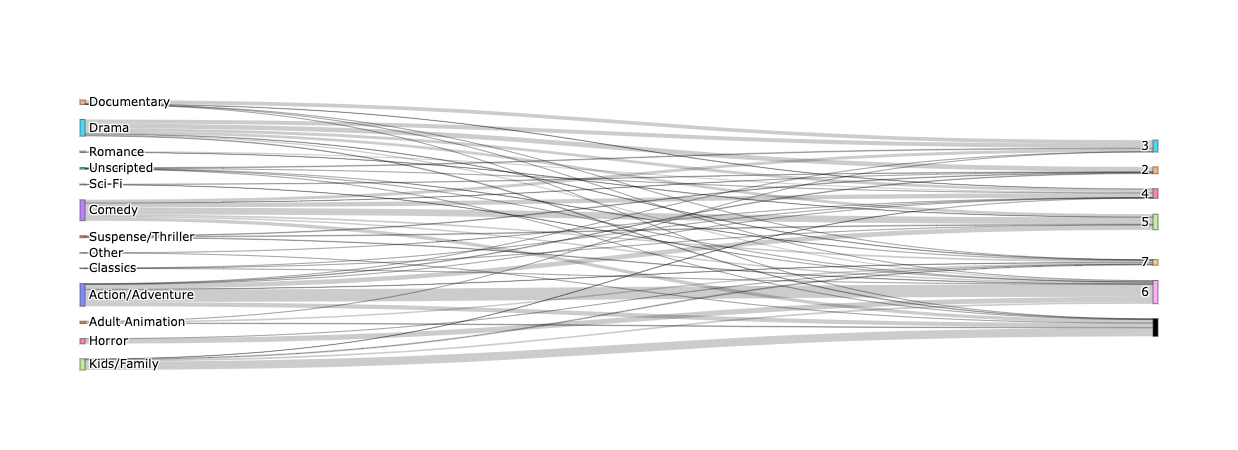

In [33]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.show()